In [4]:
%matplotlib inline

import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from hep2_classification.segmentation import SegmentationResult
from hep2_classification.presentation import display_grid, ImagePlotter

from numpy.random import seed
import json
seed(123)

## dataset files count for each type

In [5]:
data_dir = '../data/segmented_v2/'

def get_type_by_filename(filename):
    return filename.split('/')[-1].split('-')[0]

files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
files_dict = {}

for f in files:
    type_ = get_type_by_filename(f)
    files_list = files_dict.get(type_, [])
    files_dict[type_] = files_list + [f]
    
for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

NEG: 180
ZIA: 492
ZIA+NUC: 180
ACA: 57
ZIA+CYT: 40
ZIA+HOM: 120
NUC: 16
HOM: 70
DOT: 9
FIB: 27
AMA: 5


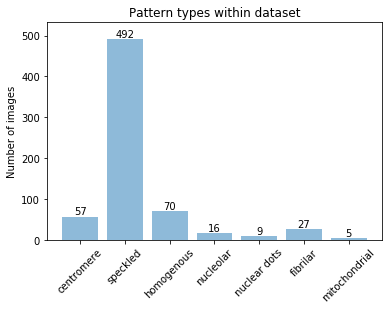

In [6]:
types = {
    'ACA': 'centromere',
    'ZIA': 'speckled',
    'HOM': 'homogenous',
    'NUC': 'nucleolar',
    'DOT': 'nuclear dots',
    'FIB': 'fibrilar',
    'AMA': 'mitochondrial'
}

y_pos = np.arange(len(types))
count = [len(files_dict[key]) for key in types.keys()]

plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, types.values(), rotation=45)
plt.ylabel('Number of images')
plt.title('Pattern types within dataset')
plt.ylim((0, max(count) + 40))

for i in range(len(count)):
    plt.text(x=y_pos[i]-(0.072 * len(str(count[i]))), y=count[i]+5, s=count[i], size=10)


## loading segmented cells data

In [7]:
selected_classes = ['ZIA', 'HOM', 'ACA', 'FIB']

selected_files = [v for k, v in files_dict.items() if k in selected_classes]
for k, v in zip(selected_classes, selected_files):
    print(f'{k}: {len(v)}')

ZIA: 492
HOM: 57
ACA: 70
FIB: 27


In [8]:
test_split = 0.3
train_files = []
test_files = []

for files in selected_files:
    test_count = int(test_split * len(files))
    split_index = len(files) - test_count
    train_files.append(files[:split_index])
    test_files.append(files[split_index:])
    
for i, name in enumerate(selected_classes):
    print(f'{name}: training - {len(train_files[i])}, test - {len(test_files[i])}')

ZIA: training - 345, test - 147
HOM: training - 40, test - 17
ACA: training - 49, test - 21
FIB: training - 19, test - 8


In [9]:
def preprocess(img, target_shape):
    
    def middle_crop(cell):
        h, w = cell.shape
        shorter = min(h, w)
        
        h_skip = (h - shorter) // 2
        v_skip = (w - shorter) // 2
        
        return cell[h_skip:h_skip+shorter, v_skip:v_skip+shorter]
    
    img = cv2.resize(middle_crop(img), target_shape)
    img = img[..., np.newaxis]
    return img / 255

def load(files, cell_shape):
    cells = []
    for f in files:
        segmented = list(SegmentationResult.load(f).cells)
        cells += segmented
        
    cells = [preprocess(c, cell_shape) for c in cells]
    return np.array(cells)

def generate_dataset(cells):
    X = []
    y = []
    for i, c in enumerate(cells):
        X.append(c)
        y.append([i] * len(c))
        
    return np.concatenate(X), np.concatenate(y)

def dataset_summary(y):
    labels = selected_classes
    counts = [np.sum(y == c) for c in range(len(selected_classes))]
    explode = [0.03] * len(labels)

    fig1, ax1 = plt.subplots()
    ax1.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Segmented cells balance')
    plt.show()
    
def trim_dataset(X, y):
    counts = [np.sum(y == c) for c in range(len(selected_classes))]
    min_count = min(counts)
    X_trimmed = []
    y_trimmed = []
    
    for i in range(len(selected_classes)):
        Xi = X[y == i]
        X_trimmed.append(Xi[:min_count])
        y_trimmed.append(np.array([i] * min_count))
        
    return np.concatenate(X_trimmed), np.concatenate(y_trimmed)

In [10]:
%%time

cell_shape = (96, 96)

train_cells = [load(files, cell_shape) for files in train_files]
test_cells = [load(files, cell_shape) for files in test_files]

X_test, y_test = generate_dataset(test_cells)

CPU times: user 18 s, sys: 1.88 s, total: 19.9 s
Wall time: 20 s


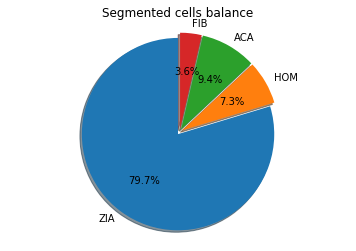

In [11]:
dataset_summary(y_test)

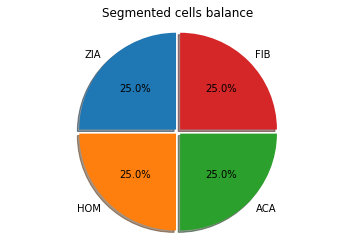

In [12]:
X_test_trim, y_test_trim = trim_dataset(X_test, y_test)
dataset_summary(y_test_trim)

In [13]:
X_test_trim.shape, X_test.shape

((1376, 96, 96, 1), (9518, 96, 96, 1))

In [14]:
print('training statistics')

for i, name in enumerate(selected_classes):
    print(f'{name}: {len(train_cells[i])} cells')

training statistics
ZIA: 17090 cells
HOM: 1916 cells
ACA: 2230 cells
FIB: 790 cells


In [15]:
print('testing statistics')

for i, name in enumerate(selected_classes):
    print(f'{name}: {len(test_cells[i])} cells')

testing statistics
ZIA: 7583 cells
HOM: 698 cells
ACA: 893 cells
FIB: 344 cells


## creating data generators

In [16]:
class SingleCellDataGenerator:
    def __init__(self, cells, batch_size, cell_lambda=None):
        self.cells = cells
        self.batch_size = batch_size
        self.order = []
        self.cell_lambda = cell_lambda

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        order = self.order
        while len(order) < self.batch_size:
            next_order_part = list(range(len(self.cells)))
            np.random.shuffle(next_order_part)
            order += next_order_part
            
        order_prefix = order[:self.batch_size]
        self.order = order[self.batch_size:]
        
        selected_cells = self.cells[order_prefix]
        
        if self.cell_lambda is not None:
            selected_cells = np.apply_along_axis(self.cell_lambda, axis=0, arr=selected_cells)
        
        return selected_cells
    
def cell_data_generator(cells, batch_size, cell_lambda=None, shuffle=True):

    classes = len(cells)
    cells_of_type_per_batch = batch_size // classes

    generators = [SingleCellDataGenerator(cells_of_type, cells_of_type_per_batch, cell_lambda)
                  for cells_of_type in cells]

    generators = generators
    cells_of_type_per_batch = cells_of_type_per_batch
    shuffle = shuffle

    while True:
        X = []
        y = []

        for i, g in enumerate(generators):
            X.append(next(g))
            y.append([i] * cells_of_type_per_batch)

        X = np.concatenate(X)
        y = np.concatenate(y)

        if shuffle:
            indices = np.array(list(range(X.shape[0])))
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

        yield X, y

## training model

In [21]:
classes_number = len(selected_classes)

model_input = keras.Input(shape=(cell_shape[0], cell_shape[1], 1), name='img')
x = layers.Conv2D(8, 11, activation='relu')(model_input)
x = layers.Conv2D(8, 11, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(8, 7, activation='relu')(x)
x = layers.Conv2D(8, 7, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(8, 5, activation='relu')(x)
x = layers.Conv2D(8, 5, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation='relu')(x)
model_output = layers.Dense(classes_number, activation='softmax')(x)

model = keras.Model(model_input, model_output, name='cells-classifier')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 86, 86, 8)         976       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 76, 76, 8)         7752      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 8)         3144      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 8)         3144      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 8)    

In [22]:
batch_size = 128
steps_per_epoch = 10
epochs = 100

generator = cell_data_generator(train_cells, batch_size=batch_size)

In [23]:
%%time

history = model.fit_generator(
    generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    validation_data=(X_test_trim, y_test_trim)
)

Epoch 1/100
10/10 [==============================] - 19s 2s/step - loss: 1.3765 - acc: 0.2578 - val_loss: 1.3188 - val_acc: 0.3183
Epoch 2/100
10/10 [==============================] - 19s 2s/step - loss: 1.2827 - acc: 0.3914 - val_loss: 1.2195 - val_acc: 0.4884
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 1.1435 - acc: 0.4625 - val_loss: 1.0936 - val_acc: 0.4818
Epoch 4/100
10/10 [==============================] - 18s 2s/step - loss: 1.1390 - acc: 0.4461 - val_loss: 1.1012 - val_acc: 0.4978
Epoch 5/100
10/10 [==============================] - 18s 2s/step - loss: 1.0594 - acc: 0.4812 - val_loss: 0.9802 - val_acc: 0.5298
Epoch 6/100
10/10 [==============================] - 19s 2s/step - loss: 1.0450 - acc: 0.5453 - val_loss: 1.2357 - val_acc: 0.4506
Epoch 7/100
10/10 [==============================] - 18s 2s/step - loss: 1.1158 - acc: 0.5172 - val_loss: 1.0601 - val_acc: 0.5312
Epoch 8/100
10/10 [==============================] - 19s 2s/step - loss: 1.0308 - a

10/10 [==============================] - 18s 2s/step - loss: 0.5862 - acc: 0.7781 - val_loss: 0.6877 - val_acc: 0.7391
Epoch 64/100
10/10 [==============================] - 18s 2s/step - loss: 0.6185 - acc: 0.7602 - val_loss: 0.6428 - val_acc: 0.7515
Epoch 65/100
10/10 [==============================] - 18s 2s/step - loss: 0.5950 - acc: 0.7766 - val_loss: 0.6615 - val_acc: 0.7398
Epoch 66/100
10/10 [==============================] - 17s 2s/step - loss: 0.6104 - acc: 0.7648 - val_loss: 0.7823 - val_acc: 0.6788
Epoch 67/100
10/10 [==============================] - 18s 2s/step - loss: 0.6369 - acc: 0.7563 - val_loss: 0.7397 - val_acc: 0.6977
Epoch 68/100
10/10 [==============================] - 18s 2s/step - loss: 0.5631 - acc: 0.7773 - val_loss: 0.6387 - val_acc: 0.7624
Epoch 69/100
10/10 [==============================] - 18s 2s/step - loss: 0.5829 - acc: 0.7820 - val_loss: 0.6420 - val_acc: 0.7449
Epoch 70/100
10/10 [==============================] - 18s 2s/step - loss: 0.5849 - acc: 0

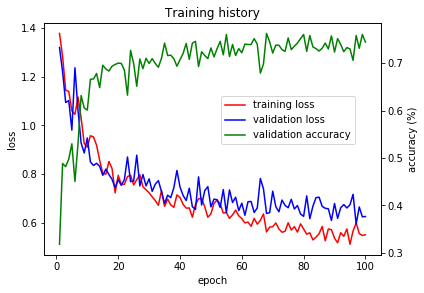

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

x = list(range(1, len(train_loss) + 1))

# plt.plot(x, train_loss, c='red', label='training loss')
# plt.plot(x, val_loss, c='blue', label='validation loss')
# plt.legend()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(x, train_loss, color='red', label='training loss')
ax1.plot(x, val_loss, color='blue', label='validation loss')
ax2 = ax1.twinx()

ax2.set_ylabel('accuracy (%)')
ax2.plot(x, val_acc, color='green', label='validation accuracy')

fig.tight_layout()
fig.legend(loc='lower left', bbox_to_anchor=(0.5, 0.5))

# plt.ylim((0, 1.3))
plt.title("Training history")
plt.show()

In [31]:
model_dir = ... # be careful not to overwrite existing model
model.save(model_dir + 'model.h5')

In [30]:
serializable_history = {}
for k, v in history.history.items():
    serializable_history[k] = [str(float_) for float_ in v]
    
serializable_history

{'loss': ['1.3765106320381164',
  '1.282721221446991',
  '1.1435490012168885',
  '1.1390042543411254',
  '1.059413528442383',
  '1.0449626564979553',
  '1.1158025085926055',
  '1.0308491051197053',
  '0.9254324555397033',
  '0.9103068590164185',
  '0.9572490394115448',
  '0.9522708535194397',
  '0.9183612644672394',
  '0.8568909943103791',
  '0.8029852747917176',
  '0.7997254192829132',
  '0.8517610371112824',
  '0.8231414914131164',
  '0.7233319282531738',
  '0.7949375689029694',
  '0.7580325841903687',
  '0.758307284116745',
  '0.7901513814926148',
  '0.7952562808990479',
  '0.7557012259960174',
  '0.7773661732673645',
  '0.7971292614936829',
  '0.7479321181774139',
  '0.7360779941082001',
  '0.7233474135398865',
  '0.7066130578517914',
  '0.6914896786212921',
  '0.6720727920532227',
  '0.73266761302948',
  '0.6680438756942749',
  '0.6976575434207917',
  '0.6736201465129852',
  '0.6638668894767761',
  '0.7146875739097596',
  '0.7040825068950654',
  '0.6762276947498321',
  '0.66060602

In [32]:
hist_json = json.dumps(serializable_history)
f = open(model_dir + 'training_history.json', 'w')
f.write(hist_json)
f.close()

In [33]:
test_pred = model.predict(X_test_trim)
test_pred = np.argmax(test_pred, axis=1)
validation = (test_pred == y_test_trim)
np.mean(validation)

0.7441860465116279

In [36]:
incorrect_X = X_test_trim[validation == False]
incorrect_X = incorrect_X.reshape(incorrect_X.shape[:3])
incorrect_true_y = y_test_trim[validation == False]
incorrect_pred_y = test_pred[validation == False]
titles = [f'true: {selected_classes[t]}, pred: {selected_classes[p]}'
          for t, p in zip(incorrect_true_y, incorrect_pred_y)]

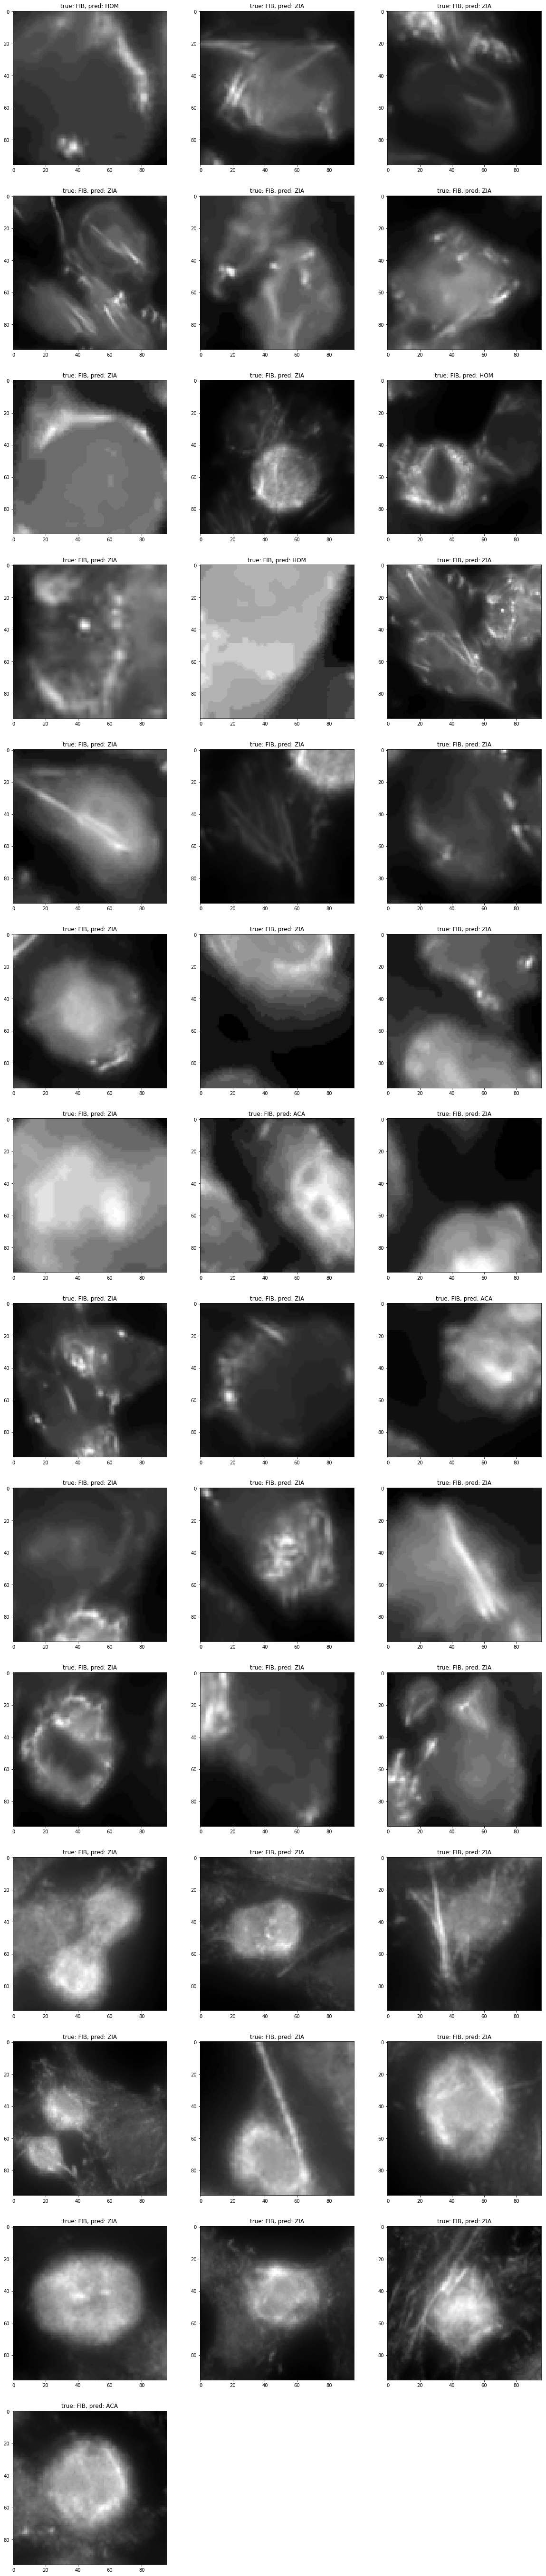

In [38]:
display_grid(incorrect_X[-40:], ImagePlotter(), titles=titles[-40:])

## loading saved model

In [26]:
reloaded = keras.models.load_model('./classifier-10.12/model.h5')
reloaded.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 86, 86, 8)         976       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 76, 76, 8)         7752      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 8)         3144      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 8)         3144      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 8)    

In [27]:
preds = reloaded.predict(X_test_trim)

In [29]:
test_pred = np.argmax(preds, axis=1)
validation = (test_pred == y_test_trim)
np.mean(validation)

0.7441860465116279